Sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, binom, beta, uniform

import pymc as pm
import arviz as az

## Bernoulli Sampling

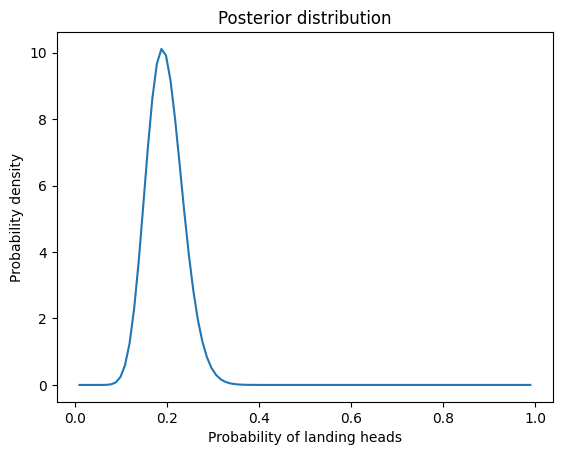

0.18818181818181817

In [2]:
def bernoulli_sampling(p, n):
    """
    Simulate n tosses of a coin which gives heads with probability 
    p. Then use that sample to calculate the posterior distribution on 
    p given a uniform prior.

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate

    Returns:
        (float): The MAP estimate of p
    """
    # Simulate n tosses of probability p
    heads_prob = np.random.binomial(n, p)
    
    p_values = np.linspace(0.01, 0.99, 100)

    # Calculate the prior
    prior_dis = uniform.pdf(p_values, loc=0, scale=1)

    # Calculate the likelihood
    likelihood = np.array([binom.pmf(heads_prob, n, p_val) for p_val in p_values])

    integral = (likelihood * prior_dis).sum() * (1 / len(p_values))
    
    # Calculate the posterior
    posterior  =  (likelihood * prior_dis) / integral

    # Calculate the MAP estimate of p
    pmap = p_values[posterior.argmax()]

    # Plot the posterior distribution
    plt.plot(p_values, posterior)
    plt.title("Posterior distribution")
    plt.xlabel("Probability of landing heads")
    plt.ylabel("Probability density")

    plt.show()

    return pmap

bernoulli_sampling(.2, 100)

## Non Uniform Prior Sampling

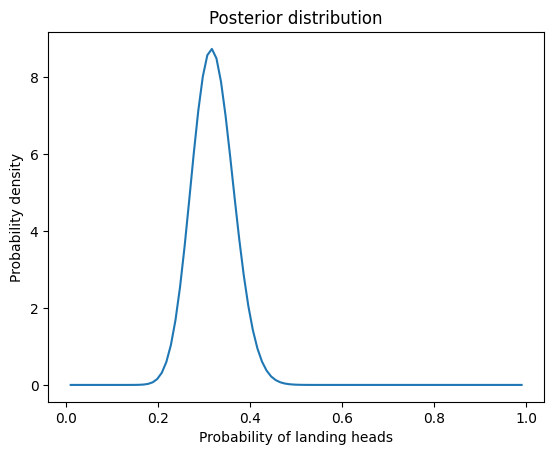

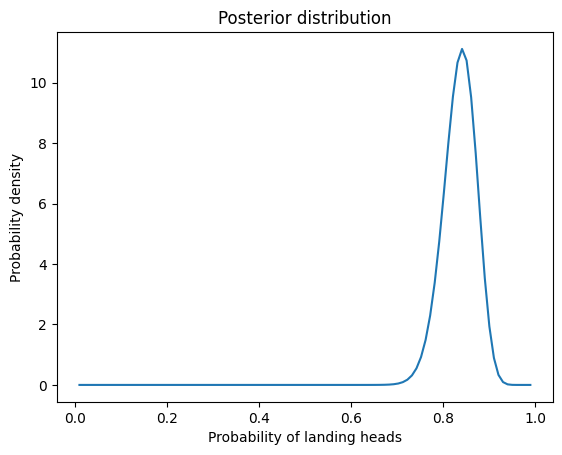

0.8415151515151514

In [6]:
def non_uniform_prior(p, n, prior):
    """
    Generate a sample of size n that has a Bernoulli
    distribution with a probability parameter p.
    Use Bayes' theorem to compute the posterior distribution
    for the given prior and the generated sample:
    
        P(t|x) = P(x|t) P(t) / P(x)
    
    Plot both prior and posterior distributions between [0, 1]

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate
        prior (scipy dist): the prior distribution on p

    Returns:
        (float): MAP estimate
    """
    
    # Simulate n tosses of probability p
    heads_prob = np.random.binomial(n, p)
    
    p_values = np.linspace(0.01, 0.99, 100)

    # Calculate the prior
    prior_dis = prior.pdf(p_values)

    # Calculate the likelihood
    likelihood = np.array([binom.pmf(heads_prob, n, p_val) for p_val in p_values])

    integral = (likelihood * prior_dis).sum() * (1 / len(p_values))
    
    # Calculate the posterior
    posterior  =  (likelihood * prior_dis) / integral

    # Calculate the MAP estimate of p
    pmap = p_values[posterior.argmax()]

    # Plot the posterior distribution
    plt.plot(p_values, posterior, label="Posterior distribution")
    plt.xlabel("Probability of landing heads")
    plt.ylabel("Probability density")
    plt.title("Posterior distribution")
    plt.show()

    return pmap
non_uniform_prior(0.4, 100, beta(5, 1.5))
non_uniform_prior(0.9, 100, beta(5, 1.5))


In [5]:
def weather_forecast(transition_matrix, days=10):
    """
    Given the above transition matrix and assuming the 0th day is sunny,
    sample from the markov chain to give a possible forecast of the 10 following
    days. Return a list of strings, not including the 0th day.
    """
    # Define states and set the 0th state to sun
    possible_states = ['sun', 'rain', 'wind']
    current_state = 'sun'

    # Initialize list of weather forecast
    walk = []

    # Cycle through each day, choose weather for next day, then update current state to that weather for each day
    for _ in range(days):
        next_day_weather = np.random.choice(possible_states, p = transition_matrix[possible_states.index(current_state)])
        walk.append(next_day_weather)
        current_state = next_day_weather

    return walk

In [6]:
transition_matrix = np.array(
  [
    [0.6, 0.1, 0.3],
    [0.2, 0.6, 0.2],
    [0.3, 0.4, 0.3]
  ]
)
weather_forecast(transition_matrix)

['wind', 'sun', 'rain', 'sun', 'wind', 'rain', 'wind', 'rain', 'rain', 'wind']

## Posterior Sampling

In [7]:
def posterior_sampling(data, n=1000):
    """
    Given data that flips a coin 100 times, assume the data are distributed 
    as Bernoulli(p) for some unknown value of p, where p has a prior of 
    Beta(1,1). Set up a PyMC model for this situation and sample from the 
    poterior n times. Plot the trace plot and return the expected value of
    the posterior.
    
    Parameters:
        data (array): The coin flips
        n (int): number of samples to take from the posterior
        
    Returns:
        Mean (float): The average of the coin flips (expected value of p)
    """
    
    # Set up pyMC model
    with pm.Model() as model:
        # Define the prior of p
        p = pm.Beta('p', alpha=1, beta=1)
      
        # Obtain the likelihood
        y = pm.Bernoulli('y', p=p, observed=data)

        # Sample from the posterior n times to obtain the trace
        trace = pm.sample(n)

        # Plot the trace plot
        az.plot_trace(trace)
        plt.show()

        # Get the expected value of the posterior
        mean = float(trace.posterior['p'].mean().values)

    return mean

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


/opt/homebrew/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


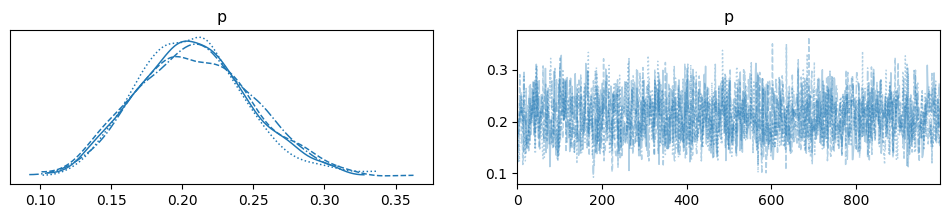

0.20802368214581146

In [8]:
data = bernoulli.rvs(0.2, size=100)
posterior_sampling(data)

In [9]:
def height_model(observed_heights, m=180, s=10, alpha=2, beta=10, n=1000):
    """
    Given a dataset of the measured heights of 100 men, assume the data are
    distributed as Normal(mu, 1/tau) where mu has a prior of Normal(m, s), 
    and tau has a prior of Gamma(alpha, beta). Set up a PyMC model for this 
    situation and sample from the posterior n times. Plot the trace plots for 
    mu and tau, and return the expected value of the posterior of mu.
    
    Parameters:
        observed_heights (array): The measured heights of 100 men
        m (int): the mean in the prior distribution of mu
        s (int): the standard deviation in the prior distribution of mu
        alpha (int): the first component in the prior distibution of tau
        beta (int): the second component in the prior distribution of tau
        n (int): number of samples from the posterior
        
    Returns:
        mu_mean (float): the estimated value of mu
    """
    # Setup PyMC model
    with pm.Model() as model:
        # Get the priors for mu and tau
        mu_prior = pm.Normal('mu', mu=m, sigma=s)
        tau_prior = pm.Gamma('tau', alpha=alpha, beta=beta)

        # Obtain the likelihood
        y = pm.Normal('y', mu=mu_prior, tau=1/tau_prior, observed=observed_heights)
      
        # Sample from the posterior n times to obtain the trace
        trace = pm.sample(n)

        # Plot the trace plot
        az.plot_trace(trace)
        plt.show()

        # Get the expected value of the posterior of mu
        mean = float(trace.posterior['mu'].mean().values)

    return mean

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau]


/opt/homebrew/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


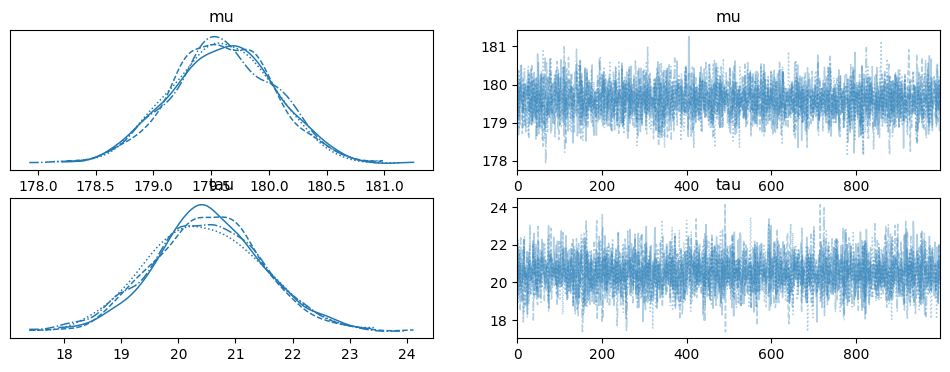

179.59801885100393

In [10]:
heights = np.random.normal(180, 10, 100)
height_model(heights)